## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

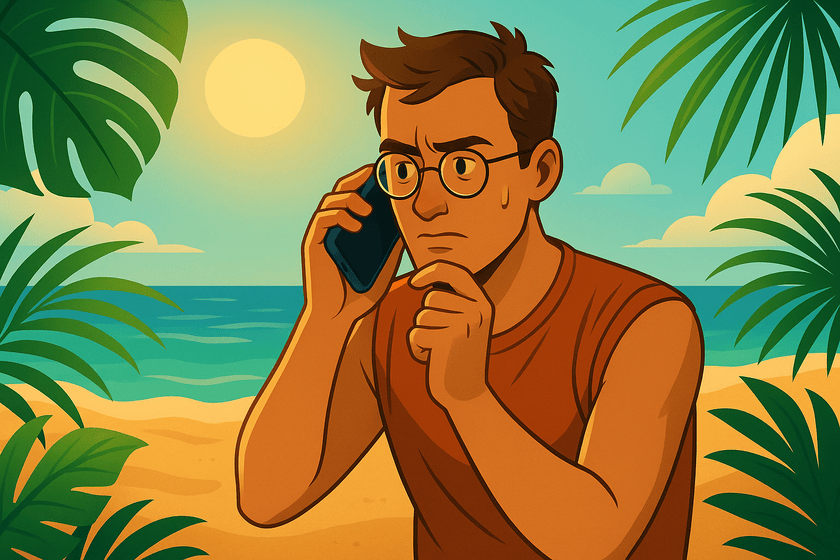

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

### Sprawdzę jak poradzi sobie z zadaniem prosta sieć neuronowa oraz konwolucyjna sieć neuronowa. Kryterium będzie dokładność wytrenowanego modelu na zbiorze testowym

### Importy i funkcje

In [69]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.optim import Adam


from sklearn.metrics import confusion_matrix, classification_report

import itertools
import time
import random

SEED = 17
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
def training(model, epochs, lr, train_loader, val_loader):
    EPOCHS = epochs
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    def run_epoch(loader, train: bool):
        epoch_loss, correct, total = 0.0, 0, 0
        if train:
            model.train()
        else:
            model.eval()
        for xb, yb in loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            if train:
                optimizer.zero_grad()
            with torch.set_grad_enabled(train):
                logits = model(xb)
                loss = criterion(logits, yb)
                if train:
                    loss.backward()
                    optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        return epoch_loss / total, correct / total

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    start = time.time()
    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = run_epoch(train_loader, train=True)
        va_loss, va_acc = run_epoch(val_loader, train=False)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
    print(f"Czas treningu: {time.time()-start:.1f}s")
    return history

In [71]:
def plt_loss_acc(history):
    plt.figure(figsize=(6,6))
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="val loss")
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="train acc")
    plt.plot(history["val_acc"], label="val acc")
    plt.xlabel("Epoka")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [72]:
def plt_conf_matrix(model, test_loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    test_acc = (y_pred == y_true).mean()
    print(f"Test accuracy: {test_acc:.4f}")


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix (MNIST)")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Prawdziwa klasa')
    plt.xlabel('Predykcja')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true, y_pred, digits=4))

### Prosta sieć neuronowa
Sprawdzam jak poradzi sobie prosta sieć neuronowa na mniejszej ilości próbek

In [73]:
train_full = TensorDataset(torch.tensor(x_train[:11000]).unsqueeze(1).float()/255.0, torch.tensor(y_train[:11000]).long())

val_size = 1000
train_size = 10000
train_ds, val_ds = random_split(train_full, [10000, 1000], generator=torch.Generator().manual_seed(SEED))

test_ds = TensorDataset(torch.tensor(x_test).unsqueeze(1).float()/255.0, torch.tensor(y_test).long())

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [74]:
class SimpleNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc1  = nn.Linear(28*28, 32)
        self.fc2  = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model_1 = SimpleNN()

In [75]:
history = training(model_1, 5, 1e-3, train_loader, val_loader)

c:\Users\milen\miniconda3\envs\ml\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 1.3281 acc 0.7050 | val loss 0.6706 acc 0.8580
Ep 02/5 | train loss 0.5335 acc 0.8702 | val loss 0.4180 acc 0.9020
Ep 03/5 | train loss 0.3940 acc 0.8978 | val loss 0.3458 acc 0.9050
Ep 04/5 | train loss 0.3351 acc 0.9102 | val loss 0.3082 acc 0.9130
Ep 05/5 | train loss 0.3002 acc 0.9189 | val loss 0.2843 acc 0.9230
Czas treningu: 34.0s


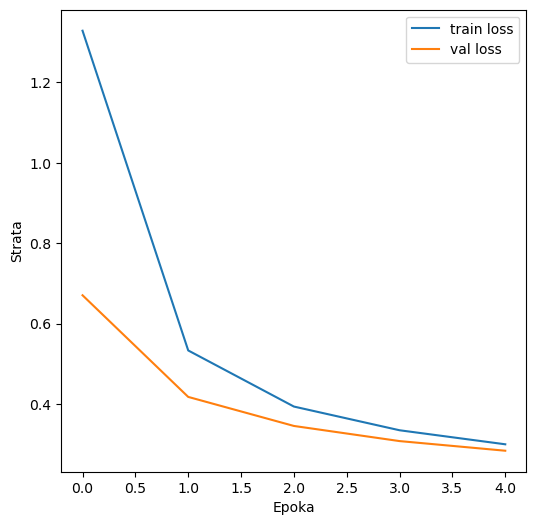

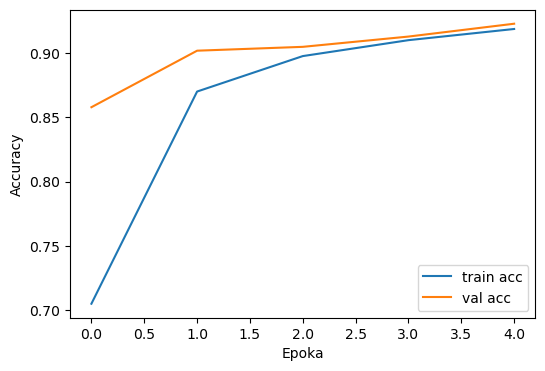

In [76]:
plt_loss_acc(history)

Test accuracy: 0.9124


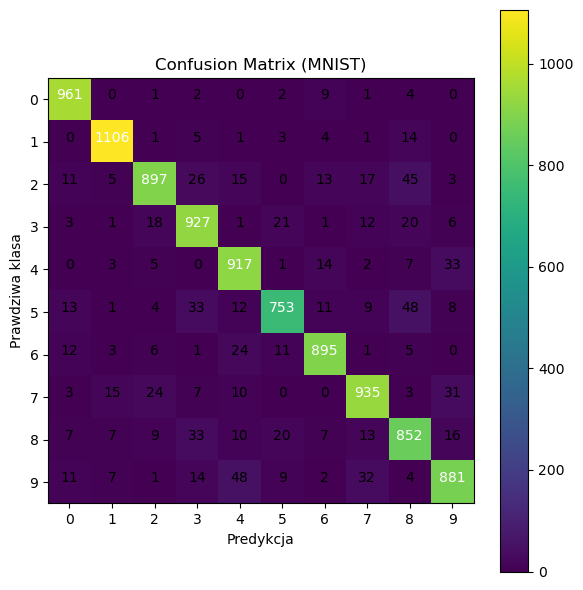

              precision    recall  f1-score   support

           0     0.9412    0.9806    0.9605       980
           1     0.9634    0.9744    0.9689      1135
           2     0.9286    0.8692    0.8979      1032
           3     0.8845    0.9178    0.9009      1010
           4     0.8834    0.9338    0.9079       982
           5     0.9183    0.8442    0.8797       892
           6     0.9362    0.9342    0.9352       958
           7     0.9140    0.9095    0.9118      1028
           8     0.8503    0.8747    0.8623       974
           9     0.9008    0.8731    0.8868      1009

    accuracy                         0.9124     10000
   macro avg     0.9121    0.9112    0.9112     10000
weighted avg     0.9128    0.9124    0.9122     10000



In [77]:
plt_conf_matrix(model_1, test_loader)

Na zbiorze testowym model osiąga dokładność ok. 92%, zobaczymy czy CNN poradzi sobie lepiej

### Konwolucyjna sieć neuronowa

In [78]:
train_full = TensorDataset(torch.tensor(x_train).unsqueeze(1).float()/255.0, torch.tensor(y_train).long())

val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

test_ds = TensorDataset(torch.tensor(x_test).unsqueeze(1).float()/255.0, torch.tensor(y_test).long())

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [79]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_2 = SimpleCNN().to(device)

In [80]:
history = training(model_2, 5, 1e-3, train_loader, val_loader)

c:\Users\milen\miniconda3\envs\ml\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 0.2801 acc 0.9135 | val loss 0.0688 acc 0.9804
Ep 02/5 | train loss 0.0764 acc 0.9769 | val loss 0.0457 acc 0.9864
Ep 03/5 | train loss 0.0576 acc 0.9821 | val loss 0.0385 acc 0.9886
Ep 04/5 | train loss 0.0461 acc 0.9861 | val loss 0.0365 acc 0.9896
Ep 05/5 | train loss 0.0395 acc 0.9875 | val loss 0.0299 acc 0.9912
Czas treningu: 167.2s


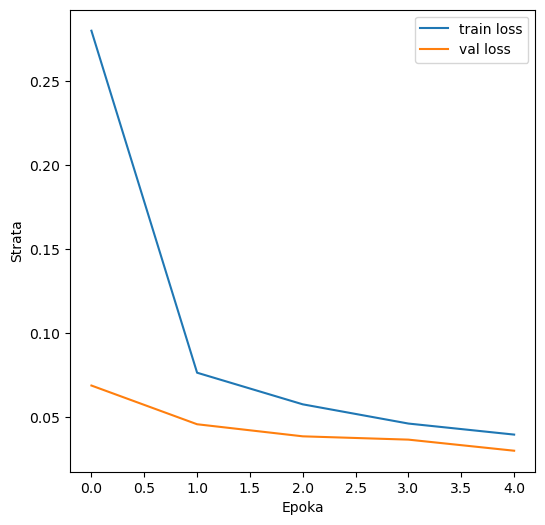

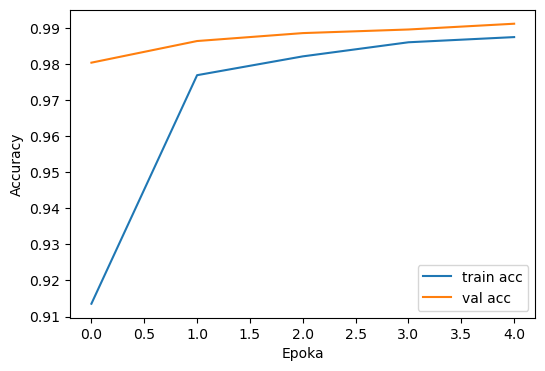

In [81]:
plt_loss_acc(history)

Test accuracy: 0.9920


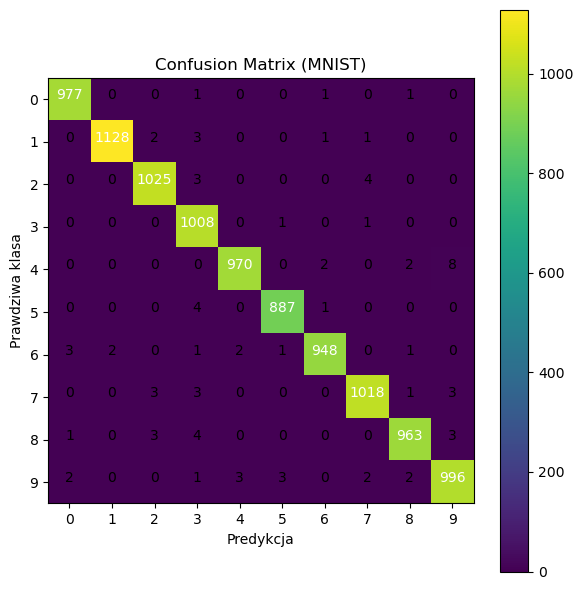

              precision    recall  f1-score   support

           0     0.9939    0.9969    0.9954       980
           1     0.9982    0.9938    0.9960      1135
           2     0.9923    0.9932    0.9927      1032
           3     0.9805    0.9980    0.9892      1010
           4     0.9949    0.9878    0.9913       982
           5     0.9944    0.9944    0.9944       892
           6     0.9948    0.9896    0.9922       958
           7     0.9922    0.9903    0.9912      1028
           8     0.9928    0.9887    0.9907       974
           9     0.9861    0.9871    0.9866      1009

    accuracy                         0.9920     10000
   macro avg     0.9920    0.9920    0.9920     10000
weighted avg     0.9920    0.9920    0.9920     10000



In [82]:
plt_conf_matrix(model_2, test_loader)

Wyswietlam przykładowe pomyłki:

c:\Users\milen\miniconda3\envs\ml\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


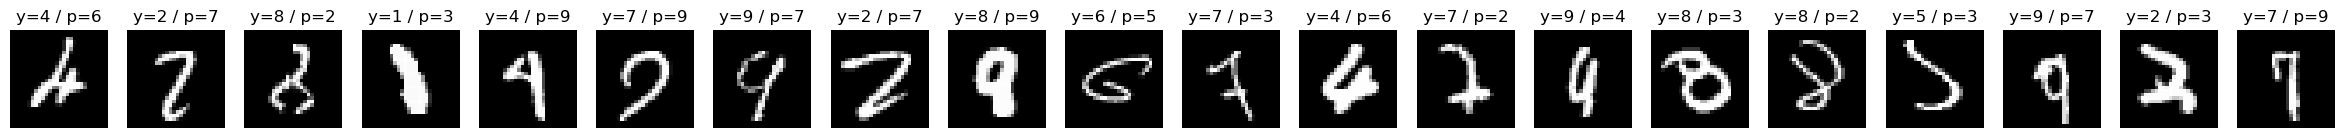

In [83]:
model_2.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model_2(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

indexes = []
j=0
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:
        j+=1
        indexes.append(i)
    if j==20:
        break

fig, axes = plt.subplots(1, len(indexes), figsize=(30, 10))
for i in indexes:
    ax = axes[indexes.index(i)]
    ax.imshow(x_test[i], cmap='gray')
    ax.set_title(f"y={y_true[i]} / p={y_pred[i]}")
    ax.axis('off')
plt.show()

Tutaj mamy 99% dokładności, czyli zauważalnie lepiej niż w pierwszej sieci :D Jak przeglądałam niektóre pomyłki to się nie dziwię, bo też bym mogła się nie domyślić

### Zmiana struktury sieci
Próbowałam, ale nie udało mi się poprawić dokładności

#### Dodanie dodatkowej warstwy liniowej lekko pogorszyło dokładność

In [84]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_3 = SimpleCNN().to(device)

In [85]:
history = training(model_3, 5, 1e-3, train_loader, val_loader)

Ep 01/5 | train loss 0.3464 acc 0.8902 | val loss 0.0736 acc 0.9778
Ep 02/5 | train loss 0.0894 acc 0.9721 | val loss 0.0445 acc 0.9862
Ep 03/5 | train loss 0.0642 acc 0.9801 | val loss 0.0438 acc 0.9860
Ep 04/5 | train loss 0.0527 acc 0.9833 | val loss 0.0346 acc 0.9904
Ep 05/5 | train loss 0.0460 acc 0.9858 | val loss 0.0324 acc 0.9888
Czas treningu: 148.9s


In [86]:
model_3.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model_3(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
print(classification_report(y_true, y_pred, digits=4))

Test accuracy: 0.9912
              precision    recall  f1-score   support

           0     0.9869    0.9980    0.9924       980
           1     0.9947    0.9991    0.9969      1135
           2     0.9932    0.9932    0.9932      1032
           3     0.9931    0.9911    0.9921      1010
           4     0.9859    0.9969    0.9914       982
           5     0.9856    0.9944    0.9900       892
           6     0.9968    0.9885    0.9927       958
           7     0.9941    0.9844    0.9892      1028
           8     0.9897    0.9846    0.9871       974
           9     0.9910    0.9812    0.9861      1009

    accuracy                         0.9912     10000
   macro avg     0.9911    0.9911    0.9911     10000
weighted avg     0.9912    0.9912    0.9912     10000



#### Dodanie neuronów w warstwie nieznacznie pogorszyło dokładność

In [87]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(128 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_4 = SimpleCNN().to(device)

In [88]:
history = training(model_3, 5, 1e-3, train_loader, val_loader)

c:\Users\milen\miniconda3\envs\ml\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 0.0436 acc 0.9864 | val loss 0.0354 acc 0.9892
Ep 02/5 | train loss 0.0375 acc 0.9883 | val loss 0.0359 acc 0.9898
Ep 03/5 | train loss 0.0310 acc 0.9900 | val loss 0.0353 acc 0.9898
Ep 04/5 | train loss 0.0306 acc 0.9905 | val loss 0.0297 acc 0.9908
Ep 05/5 | train loss 0.0273 acc 0.9912 | val loss 0.0380 acc 0.9884
Czas treningu: 363.9s


In [89]:
model_4.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model_3(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
print(classification_report(y_true, y_pred, digits=4))

Test accuracy: 0.9894
              precision    recall  f1-score   support

           0     0.9909    0.9969    0.9939       980
           1     0.9965    0.9956    0.9960      1135
           2     0.9932    0.9874    0.9903      1032
           3     0.9693    0.9990    0.9839      1010
           4     0.9918    0.9908    0.9913       982
           5     0.9932    0.9854    0.9893       892
           6     0.9958    0.9854    0.9906       958
           7     0.9836    0.9903    0.9869      1028
           8     0.9968    0.9723    0.9844       974
           9     0.9842    0.9891    0.9867      1009

    accuracy                         0.9894     10000
   macro avg     0.9895    0.9892    0.9893     10000
weighted avg     0.9895    0.9894    0.9894     10000

